<a href="https://colab.research.google.com/github/lplugof62/lorena_lugo_KC/blob/main/Taller_Semana7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller

## Recapitulando clustering
- Crear una matriz de distancia usando criterio de enlace
    - ```method```: como calcular la proximidad de los clusters
    - ```metric```: metrica de distancia
    - ```optimal_ordering```: Orden de los puntos 
- Tipos de method
    - single: basado en los 2 objetos mas cercanos
    - complete: basado en los dos objetos mas lejanos 
    - average: basado en la media aritmetica de todos los objetos 
    - centroids: basado en la media geometrica de todos los objetos 
    - median: basado en la median de todos los objetos 
    - ward: basado en la suma de cuadrado 

# Agrupación en el conjunto de datos del vehículo

Imagine que un fabricante de automóviles ha desarrollado prototipos para un vehículo nuevo. Antes de introducir el nuevo modelo en su gama, el fabricante quiere determinar qué vehículos existentes en el mercado se parecen más a los prototipos, es decir, cómo se pueden agrupar los vehículos, qué grupo es el más similar al modelo y, por tanto, qué modelos. estarán compitiendo contra ellos.

Nuestro objetivo aquí es utilizar métodos de agrupamiento para encontrar los grupos de vehículos más distintivos. Resumirá los vehículos existentes y ayudará a la fabricación a tomar decisiones sobre nuevos modelos de forma sencilla.

### Descargar datos
Para descargar los datos, usaremos **`!wget`**. Estos datos se encuentran alojado en una API: IBM Object Storage.
__ ¿Lo sabían? __ Cuando se trata de aprendizaje automático, es probable que trabaje con grandes conjuntos de datos. Como empresa, ¿dónde puede alojar sus datos? IBM ofrece una oportunidad única para las empresas, con 10 Tb de IBM Cloud Object Storage: [Pueden registrarse aqui](http://cocl.us/ML0101EN-IBM-Offer-CC)

In [1]:
!wget -O cars_clus.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cars_clus.csv

--2021-09-27 03:59:25--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cars_clus.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17774 (17K) [text/csv]
Saving to: ‘cars_clus.csv’

cars_clus.csv       100%[===================>]  17.36K  --.-KB/s    in 0.002s  

2021-09-27 03:59:25 (11.1 MB/s) - ‘cars_clus.csv’ saved [17774/17774]



# Leer los datos

In [3]:
import pandas as pd
filename = 'cars_clus.csv'
#Lectura
pdf = pd.read_csv(filename)
print ("Shape: ", pdf.shape)
pdf.head(5)

Shape:  (159, 16)


,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.000,21.500,1.800,140.000,101.200,67.300,172.400,2.639,13.200,28.000,2.828,0.0
1,Acura,TL,39.384,19.875,0.000,28.400,3.200,225.000,108.100,70.300,192.900,3.517,17.200,25.000,3.673,0.0
2,Acura,CL,14.114,18.225,0.000,$null$,3.200,225.000,106.900,70.600,192.000,3.470,17.200,26.000,2.647,0.0
3,Acura,RL,8.588,29.725,0.000,42.000,3.500,210.000,114.600,71.400,196.600,3.850,18.000,22.000,2.150,0.0
4,Audi,A4,20.397,22.255,0.000,23.990,1.800,150.000,102.600,68.200,178.000,2.998,16.400,27.000,3.015,0.0


Los features incluyen:
- price en thousands (price)
- engine size (engine_s)
- horsepower (horsepow)
- wheelbase (wheelbas)
- width (width)
- length (length)
- curb weight (curb_wgt)
- fuel capacity (fuel_cap) 
- fuel efficiency (mpg).

# Data cleaning

1. Observando el proceso que se observa en el codigo de abajo que pueden concluir de que se realizo ?

In [4]:
print ("Shape antes de cleaning: ", pdf.shape)
pdf[[ 'sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']] = pdf[['sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']].apply(pd.to_numeric, errors='coerce')
pdf = pdf.dropna()
pdf = pdf.reset_index(drop=True)
print ("Shape despues de cleaning: ", pdf.shape)
pdf.head(5)

Shape antes de cleaning:  (159, 16)
Shape despues de cleaning:  (117, 16)


,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0


**Respuesta**

R// Inicialmente se observa una disminución en el número de filas de la matriz, pasando de tener 159 a 117 filas. Al utilizar la función apply pd.to_numeric se convierten los valores de las columnas a tipo numérico, los que no se puedan convertir serán inválidos y quedarán de tipo NaN. Con pdf.dropna(), se eliminan las filas que contengan por lo menos un elemento nulo o NaN. Finalmente, para que los indices no queden descontinuos por las filas eliminadas, se resetea para que vuelvan a quedar ordenados y continuos.

# Feature selection

2. Seleccionar las columnas ``engine_s,  horsepow, wheelbas, width, lenght, curb_wgt, fuel_cap y mpg`` y guardarlas en el dataset ``featureset``

In [5]:
featureset = pdf[[ 'engine_s','horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap','mpg']]
featureset.head(5)

,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg
0,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0
1,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0
2,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0
3,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0
4,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0


# Clustering usando SCIpy

3. En esta parte usamos el paquete Scipy para agrupar el conjunto de datos:
Primero, calculamos la matriz de distancias.

Convertir a una matriz de distancias el dataset ``feature_set`` utilizando la funcion ``featureset.values`` y guardar el resultado en ``feature_mtx``



In [6]:
feature_mtx = featureset.values
feature_mtx

array([[  1.8  , 140.   , 101.2  ,  67.3  , 172.4  ,   2.639,  13.2  ,
         28.   ],
       [  3.2  , 225.   , 108.1  ,  70.3  , 192.9  ,   3.517,  17.2  ,
         25.   ],
       [  3.5  , 210.   , 114.6  ,  71.4  , 196.6  ,   3.85 ,  18.   ,
         22.   ],
       [  1.8  , 150.   , 102.6  ,  68.2  , 178.   ,   2.998,  16.4  ,
         27.   ],
       [  2.8  , 200.   , 108.7  ,  76.1  , 192.   ,   3.561,  18.5  ,
         22.   ],
       [  4.2  , 310.   , 113.   ,  74.   , 198.2  ,   3.902,  23.7  ,
         21.   ],
       [  2.8  , 193.   , 107.3  ,  68.5  , 176.   ,   3.197,  16.6  ,
         24.   ],
       [  2.8  , 193.   , 111.4  ,  70.9  , 188.   ,   3.472,  18.5  ,
         24.8  ],
       [  3.1  , 175.   , 109.   ,  72.7  , 194.6  ,   3.368,  17.5  ,
         25.   ],
       [  3.8  , 240.   , 109.   ,  72.7  , 196.2  ,   3.543,  17.5  ,
         23.   ],
       [  3.8  , 205.   , 113.8  ,  74.7  , 206.8  ,   3.778,  18.5  ,
         24.   ],
       [  3.8  , 205.

Con la matriz creada previamente ``feature_mtx`` correr el codigo de acontinuación (Esto consiste en encontrar una matriz de distancias entre individuos/automoviles). El resultado se guarda en una matriz D. 

**Nota** Si todo marcha en orden no deberia haber problemas con los siguientes dos segmentos de código

In [22]:
import scipy
from scipy.spatial import distance_matrix

In [23]:
leng = feature_mtx.shape[0]
D = scipy.zeros([leng,leng])
for i in range(leng):
  for j in range(leng):
    D[i,j] = scipy.spatial.distance.euclidean(feature_mtx[i], feature_mtx[j])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  


In [21]:
D

array([[  0.        ,  87.9180919 ,  75.79845989, ...,  16.63650252,
         28.07638866,  26.83496095],
       [ 87.9180919 ,   0.        ,  17.0877409 , ...,  75.60022934,
        115.3194773 , 114.3440861 ],
       [ 75.79845989,  17.0877409 ,   0.        , ...,  62.15304698,
        103.39586278, 102.0832197 ],
       ...,
       [ 16.63650252,  75.60022934,  62.15304698, ...,   0.        ,
         43.35044747,  41.45224917],
       [ 28.07638866, 115.3194773 , 103.39586278, ...,  43.35044747,
          0.        ,   3.75905427],
       [ 26.83496095, 114.3440861 , 102.0832197 , ...,  41.45224917,
          3.75905427,   0.        ]])

En la agrupación aglomerativa, en cada iteración, el algoritmo debe actualizar la matriz de distancia para reflejar la distancia del grupo recién formado con los grupos restantes en el bosque.

Los siguientes métodos son compatibles con Scipy para calcular la distancia entre el grupo recién formado y cada uno:

     - single
     - complete
     - average
     - weighted
     - centroid
    
4. Utilizaremos __complete__ para nuestro caso, pero en una proxima oportunidad siéntanse libres de cambiarlo para ver cómo cambian los resultados. Calcular el objeto Z por medio de la siguiente estructura de código:

``import pylab``

``import scipy.cluster.hierarchy``

``z=scipy.cluster.hierachy.linkage(D,'complete')``



In [26]:
import pylab
import scipy.cluster
Z = scipy.cluster.hierarchy.linkage(D, method='complete')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


Esencialmente, la agrupación jerárquica no requiere un número predeterminado de agrupaciones. Sin embargo, en algunas aplicaciones queremos una partición de clústeres disjuntos como en un clúster plano.

Entonces podemos usar una línea de corte:

In [27]:
from scipy.cluster.hierarchy import fcluster
max_d = 3
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([ 51, 102,  95,  59,  83,   3,  46,  47,  38,  80,  99,  97,   4,
         7,  84,  20,  30,  39,  40,  82,   9,  19,  29,  70,  31,  89,
        56,  78,  55,  71,  32, 108,  76,  41,  50,  13,  66,  22,  44,
        33,  73,  88,  90,  75,  81,  14,  77,  23,  58,  60,  87,  96,
        12,  52,  64, 104,  28,  42,  48,  94, 103,   8,   5, 106,  26,
        68,  65,  92,  72,  85,  35,  15,  16,  74,  88,  91,  37,  43,
       100,   6,   2,  17,  69, 101,  37,  34,  67,  79,  45,  49,  55,
        56,  66,  63,  36,  82,  86,  98, 107,   1,   1,  10,  11,  18,
        19,  57,  93,  53,  54,  21,  61, 105,  24,  27,  62,  25,  24],
      dtype=int32)

In [28]:
# Determinar clusters
from scipy.cluster.hierarchy import fcluster
k = 5
clusters = fcluster(Z, k, criterion='maxclust')
clusters

array([3, 4, 4, 3, 4, 1, 3, 3, 3, 4, 4, 4, 1, 1, 4, 2, 3, 3, 3, 4, 1, 2,
       2, 3, 3, 4, 3, 4, 3, 3, 3, 5, 4, 3, 3, 2, 3, 2, 3, 3, 3, 4, 4, 3,
       4, 2, 4, 2, 3, 3, 4, 4, 2, 3, 3, 4, 2, 3, 3, 4, 4, 1, 1, 4, 2, 3,
       3, 4, 3, 4, 3, 2, 2, 3, 4, 4, 3, 3, 4, 1, 1, 2, 3, 4, 3, 3, 3, 4,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 1, 1, 2, 2, 2, 2, 3, 4, 3, 3, 2,
       3, 4, 2, 2, 3, 2, 2], dtype=int32)

# Dendrograma

5. Utilizar el objeto ``Z`` creado previamente en la funcion ``scipy.cluster.hierarchy.dendrogram`` para obtener el dendrograma para ello pueden utilizar de ayuda el siguiente código:
`

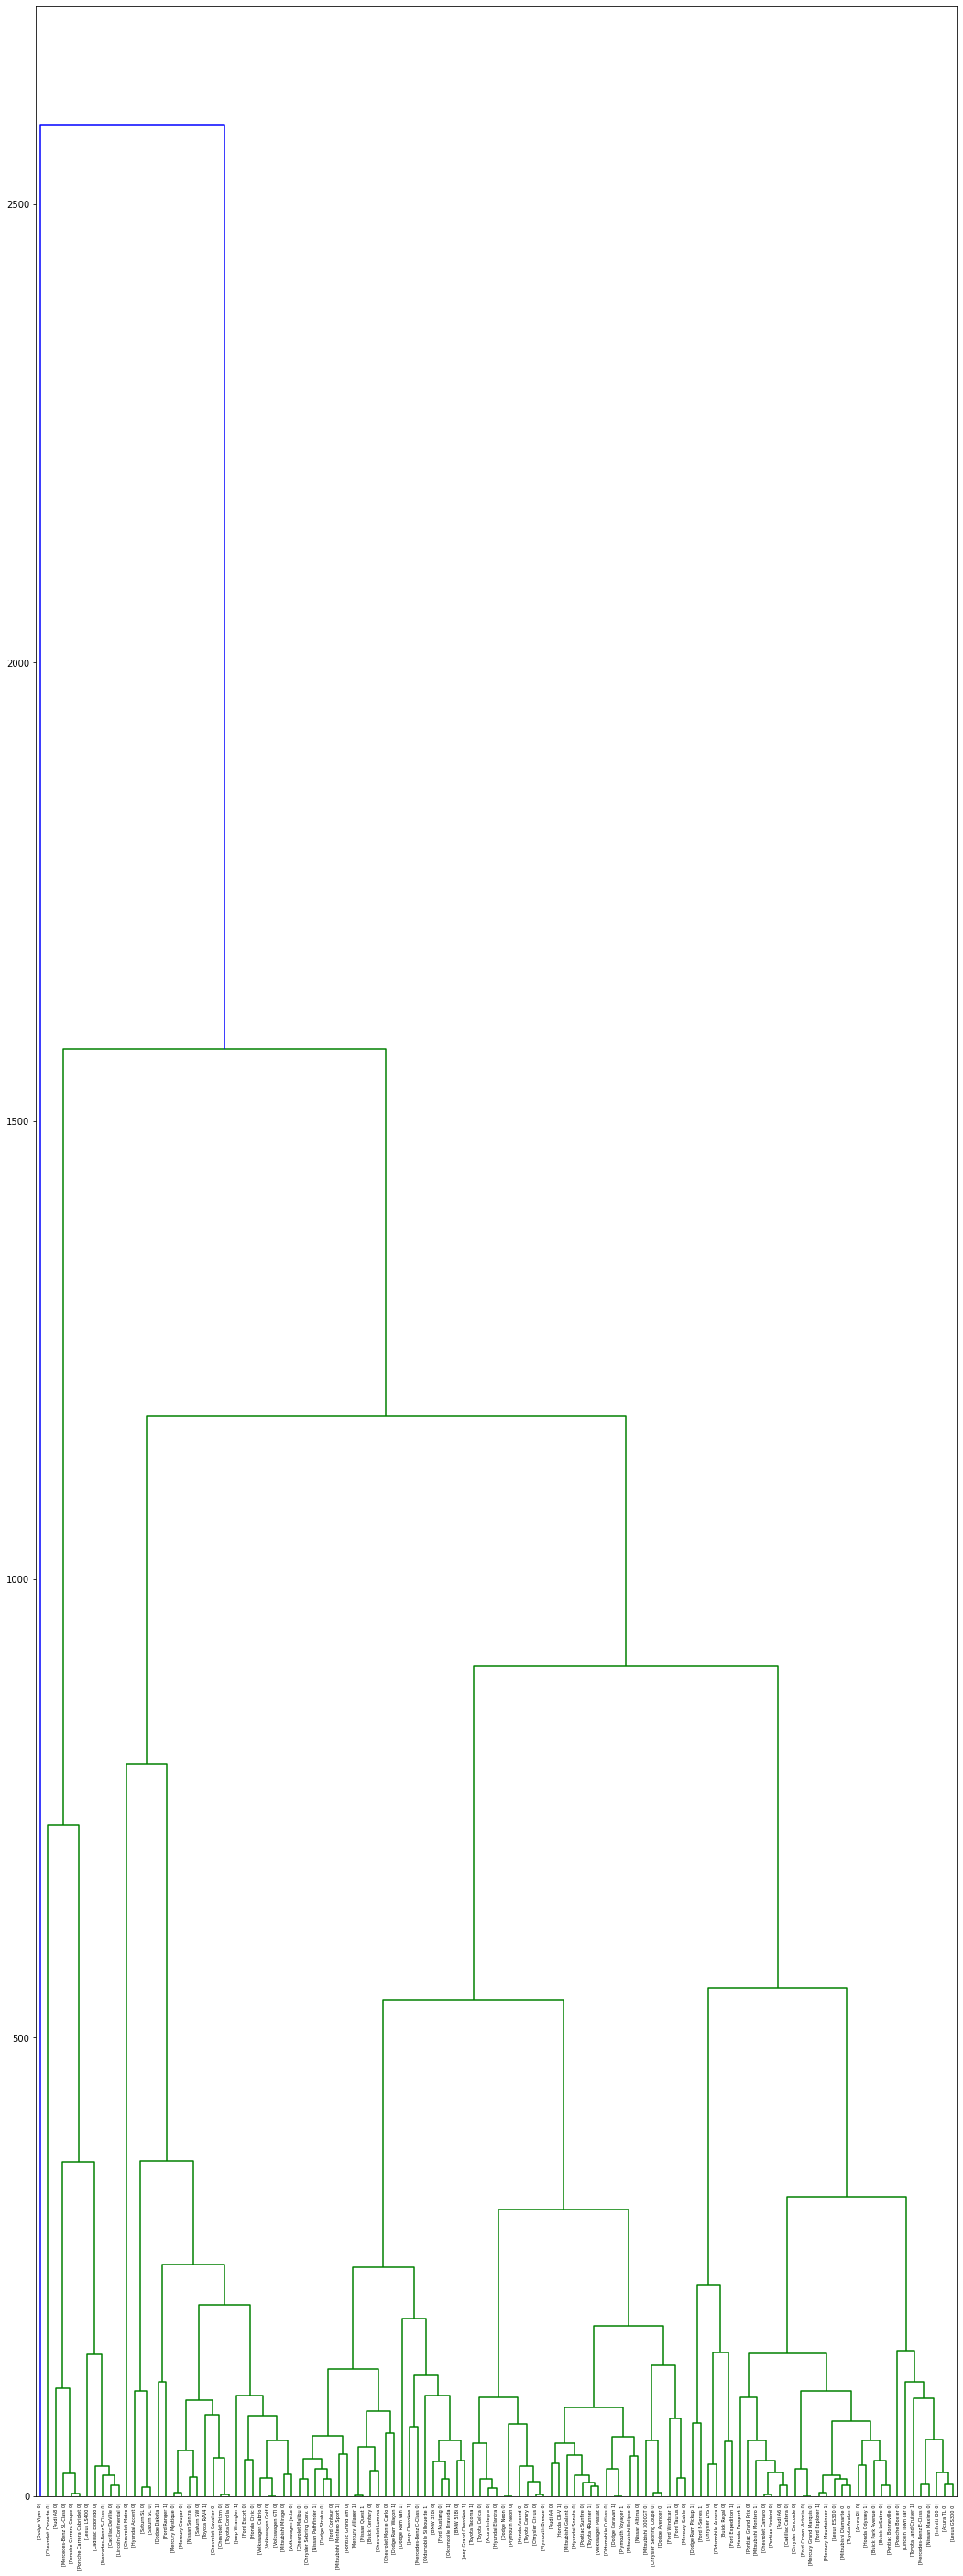

In [44]:
fig = pylab.figure(figsize=(18,50))
def llf(id):
    return '[%s %s %s]' % (pdf['manufact'][id], pdf['model'][id], int(float(pdf['type'][id])) )

dendrograma = hierarchy.dendrogram(Z,leaf_label_func=llf)

# Usando scikit learn

Ahora obtenemos la matriz de distancias usando scikit learn

In [45]:
from scipy.spatial import distance_matrix 

dist_matrix = distance_matrix(feature_mtx,feature_mtx) 
print(dist_matrix)

[[  0.          87.9180919   75.79845989 ...  16.63650252  28.07638866
   26.83496095]
 [ 87.9180919    0.          17.0877409  ...  75.60022934 115.3194773
  114.3440861 ]
 [ 75.79845989  17.0877409    0.         ...  62.15304698 103.39586278
  102.0832197 ]
 ...
 [ 16.63650252  75.60022934  62.15304698 ...   0.          43.35044747
   41.45224917]
 [ 28.07638866 115.3194773  103.39586278 ...  43.35044747   0.
    3.75905427]
 [ 26.83496095 114.3440861  102.0832197  ...  41.45224917   3.75905427
    0.        ]]


6. Utilizar el metodo ``AgglomerativeClustering`` visto en clase con ``n_clusters`` el número apropiado que consideren según en dendograma creado previamente y con propiedad ``linkage='complete'``. Guardar el modelo con el nombre``agglom``. Ajustar el modelo a los datos ``feature_mtx`` y obtener las predicciones con la funcion ``agglom.labels_``

In [58]:
from sklearn.cluster import AgglomerativeClustering
agglom = AgglomerativeClustering(n_clusters = 6, linkage = 'complete')
agglom.fit(feature_mtx)
agglom.labels_

array([2, 0, 0, 3, 0, 1, 0, 0, 3, 0, 0, 0, 1, 1, 0, 2, 3, 3, 3, 0, 1, 2,
       4, 3, 3, 0, 2, 0, 2, 3, 3, 5, 0, 3, 0, 3, 3, 2, 0, 3, 3, 0, 0, 3,
       0, 3, 0, 2, 2, 2, 0, 0, 2, 2, 3, 0, 2, 0, 0, 0, 0, 1, 1, 0, 2, 3,
       3, 0, 3, 0, 3, 2, 2, 3, 0, 0, 3, 0, 0, 1, 1, 2, 3, 0, 3, 3, 3, 0,
       0, 0, 2, 2, 3, 3, 3, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       3, 0, 2, 2, 3, 2, 2])

7. Crear una columna en el dataset pdf que se llame ``cluster_`` con base en los labels obtenidos con ``agglom.labels_''

In [59]:
pdf['cluster_'] = agglom.labels_
pdf.head(10)

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition,cluster_
0,Acura,Integra,16.919,16.360,0.0,21.500,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0,2
1,Acura,TL,39.384,19.875,0.0,28.400,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0,0
2,Acura,RL,8.588,29.725,0.0,42.000,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0,0
3,Audi,A4,20.397,22.255,0.0,23.990,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0,3
4,Audi,A6,18.780,23.555,0.0,33.950,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0,0
5,Audi,A8,1.380,39.000,0.0,62.000,4.2,310.0,113.0,74.0,198.2,3.902,23.7,21.0,0.322,0.0,1
6,BMW,328i,9.231,28.675,0.0,33.400,2.8,193.0,107.3,68.5,176.0,3.197,16.6,24.0,2.223,0.0,0
7,BMW,528i,17.527,36.125,0.0,38.900,2.8,193.0,111.4,70.9,188.0,3.472,18.5,24.8,2.864,0.0,0
8,Buick,Century,91.561,12.475,0.0,21.975,3.1,175.0,109.0,72.7,194.6,3.368,17.5,25.0,4.517,0.0,3
9,Buick,Regal,39.350,13.740,0.0,25.300,3.8,240.0,109.0,72.7,196.2,3.543,17.5,23.0,3.672,0.0,0


8. Utilizar el siguiente codigo (Primero deben entenderlo) para crear una grafica de dispersion entre ``mpg`` y ``horsepow`` donde se proyecta como tercera variable el ``price``. Con base en esta grafica obtener una descripcion de cada cluster.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Text(0, 0.5, 'mpg')

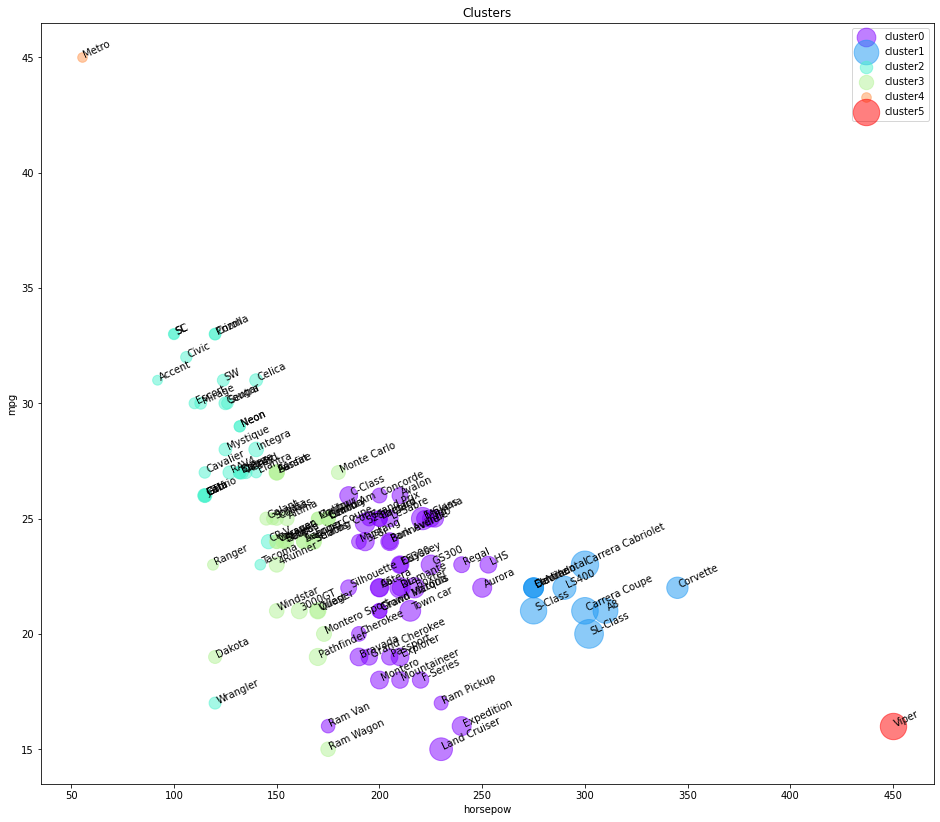

In [60]:
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
n_clusters = max(agglom.labels_)+1
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))

# Figura de tamaño 16 inches por 14 inches.
plt.figure(figsize=(16,14))

for color, label in zip(colors, cluster_labels):
    subset = pdf[pdf.cluster_ == label]
    for i in subset.index:
            plt.text(subset.horsepow[i], subset.mpg[i],str(subset['model'][i]), rotation=25) 
    plt.scatter(subset.horsepow, subset.mpg, s= subset.price*10, c=color, label='cluster'+str(label),alpha=0.5)
#    plt.scatter(subset.horsepow, subset.mpg)
plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg')

In [63]:
details_cars = pdf.groupby(['cluster_'])['price'].mean()
details_cars

cluster_
0    29.888791
1    57.864000
2    14.871867
3    20.295500
4     9.235000
5    69.725000
Name: price, dtype: float64

**Respuesta**




**CLUSTER 0:** Representa al grupo de carros con un costo intermedio, un consumo de gasolina medio-alto y una potencia entre los 150 y los 170 horsepower aproximadamente. 

**CLUSTER 1:** Representa el segundo grupo de carros más costosos y con mayor potencia, el consumo de gasolina está entre los 20 a 25 mpg aproximadamente.

**CLUSTER 2:** Representa a segundo grupo de carros más económico, debido a su potencia baja (entre los 90 y 150 horsepower) y un amplio rango en el consumo de gasolina llegando hasta aproximadamente los 34 mpg.

**CLUSTER 3:** Representa a un grupo de carros con un consumo de gasolina de amplio rango (15 - 26 mpg), y una potencia desde los 120 a los 170 horsepower.

**CLUSTER 4:**Representa al grupo de carros más económico, contando con la mínima potencia y un consumo de gasolina muy bajo, lo cual permite que recorra más distancia con menos gasolina.

**CLUSTER 5:** Representa al grupo de carros má costosos, con la mayor potencia de 450 hp aproximadamente y un consumo de gasolina muy alto (15mpg)


9. Obtener un conteo para cada cluster y analizar si las estructuras son balanceadas? Porque?

R/ De acuerdo al conteo de vehículos por cada cluster, se puede observar que no hay un balanceo. Mientras el cluster 0 cuenta con 43 registros, el cluster 4 y 5 tienen de a un registro cada uno. Esto puede ser algo común, ya que hay más producción de carros de gama media en comparación con los de gama muy baja o muy alta, debido a la accesibilidad de los mismos.

In [61]:
pdf.groupby(['cluster_'])['cluster_'].count()

cluster_
0    43
1    10
2    30
3    32
4     1
5     1
Name: cluster_, dtype: int64